In [1]:
!pip install tensorflow shap matplotlib scikit-learn pandas


#### Outline
1. Data collection
2. Feature Engineering
3. Input Construction
4. GRU Modeling
5. GRU Model Evaluation

## 1. Data collection - Individual Stocks

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
ticker = "CSL"

file_path = "/content/drive/My Drive/Colab Notebooks/combined_stock_data.csv"
df = pd.read_csv(file_path, parse_dates=['Date'])

#df = pd.read_csv("combined_stock_data.csv", parse_dates=['Date'])
stock_df = df[df['Name'] == ticker].copy()

# Sort by date
stock_df.sort_values(by='Date', inplace=True)

# Set index
stock_df.set_index('Date', inplace=True)


# Missing values
print("\n Missing values:")
print(stock_df.isnull().sum())  # Count missing values per column
stock_df.dropna(inplace=True)

# Check column and head
print(stock_df.columns)
print(stock_df.head())

# Check the number of rows
freq_counts = stock_df['Name'].value_counts()
print(freq_counts.describe())


 Missing values:
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')
                  Open        High         Low       Close  Volume Name
Date                                                                   
2020-01-02  257.204242  260.732863  256.886016  257.428894  378816  CSL
2020-01-03  262.071286  262.979177  258.505247  259.544159  427336  CSL
2020-01-06  258.327378  259.525417  256.333760  259.076141  398061  CSL
2020-01-07  262.904278  265.815127  260.891922  265.272278  514937  CSL
2020-01-08  268.145666  268.229900  261.153979  267.546661  665873  CSL
count       1.0
mean     1266.0
std         NaN
min      1266.0
25%      1266.0
50%      1266.0
75%      1266.0
max      1266.0
Name: count, dtype: float64


## 📊 2. Features Engineering

These features combine classic time series lags, trend indicators, momentum oscillators, and volatility metrics.  
Grouped below by functional type, they provide rich information for both interpretable models and deep learning models like GRU.

---

### 🕒 Lag Features  
Understand **short-term behavior** via lags and returns.

| Column Name     | Description |
|-----------------|-------------|
| **price_lag1**   | Closing price from 1 day ago – captures immediate price momentum |
| **price_lag2**   | Closing price from 2 days ago – extends short-term memory |
| **return_lag1**  | Percentage return from 1 day ago – normalized price change (%) |

---

### 📈 Trend Indicators  
Capture **trend direction and reversals** using SMA, EMA, and price deviation.

| Column Name     | Description |
|-----------------|-------------|
| **SMA_5**        | 5-day Simple Moving Average – short-term trend average |
| **SMA_20**       | 20-day Simple Moving Average – long-term trend reference |
| **EMA_20**       | 20-day Exponential Moving Average – reacts faster to recent prices |
| **norm_price**   | Price deviation (%) from 20-day MA – normalized position relative to trend |

---

### 🔄 Momentum Indicators  
Measure **momentum and overbought/oversold conditions** via RSI and MACD.

| Column Name     | Description |
|-----------------|-------------|
| **RSI_14**       | 14-day Relative Strength Index – momentum oscillator (0–100 scale). Overbought if >70, Oversold if <30 |
| **MACD**         | Moving Average Convergence Divergence – difference between EMA(12) and EMA(26), indicates momentum direction |
| **MACD_signal**  | 9-day EMA of MACD – signal line used for MACD crossover buy/sell decisions |

---

### 🌊 Volatility Features  
Quantify **volatility and risk** using standard deviation and volatility ratios.

| Column Name       | Description |
|-------------------|-------------|
| **roll_std5**      | 5-day rolling standard deviation – short-term volatility indicator |
| **volatility_5**   | Standard deviation of 5-day returns – recent volatility measure |
| **volatility_20**  | Standard deviation of 20-day returns – longer-term volatility context |
| **vol_ratio**      | Ratio of short-term to long-term volatility (`vol_5 / vol_20`) – reflects market stability shifts |


In [8]:
import numpy as np

In [9]:
# Compute daily returns as percentage change in closing price
stock_df['returns'] = stock_df['Close'].pct_change() * 100

# ------------------------------------------
# 🕒 Lag Features
# ------------------------------------------
stock_df['price_lag1'] = stock_df['Close'].shift(1)
stock_df['price_lag2'] = stock_df['Close'].shift(2)
stock_df['return_lag1'] = stock_df['returns'].shift(1)

# ------------------------------------------
# 📈 Trend Indicators
# ------------------------------------------
stock_df['SMA_5'] = stock_df['Close'].rolling(window=5).mean()
stock_df['SMA_20'] = stock_df['Close'].rolling(window=20).mean()
stock_df['EMA_20'] = stock_df['Close'].ewm(span=20, adjust=False).mean()
stock_df['norm_price'] = (stock_df['Close'] - stock_df['SMA_20']) / stock_df['SMA_20'] * 100

# ------------------------------------------
# 🔄 Momentum Indicators
# ------------------------------------------

# RSI (14-day)
delta = stock_df['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
stock_df['RSI_14'] = 100 - (100 / (1 + rs))

# MACD and Signal Line
ema_12 = stock_df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_df['Close'].ewm(span=26, adjust=False).mean()
stock_df['MACD'] = ema_12 - ema_26
stock_df['MACD_signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()

# ------------------------------------------
# 🌊 Volatility Features
# ------------------------------------------
stock_df['roll_std5'] = stock_df['Close'].rolling(window=5).std()
stock_df['volatility_5'] = stock_df['returns'].rolling(window=5).std()
stock_df['volatility_20'] = stock_df['returns'].rolling(window=20).std()
stock_df['vol_ratio'] = stock_df['volatility_5'] / stock_df['volatility_20'].replace(0, np.nan)

In [10]:
# Missing values
print("\n Missing values:")
print(stock_df.isnull().sum())


 Missing values:
Open              0
High              0
Low               0
Close             0
Volume            0
Name              0
returns           1
price_lag1        1
price_lag2        2
return_lag1       2
SMA_5             4
SMA_20           19
EMA_20            0
norm_price       19
RSI_14           13
MACD              0
MACD_signal       0
roll_std5         4
volatility_5      5
volatility_20    20
vol_ratio        20
dtype: int64


It's normal for rolling and shift-based indicators to have NaN values in the initial rows, since they require **past data** to compute.

Especially for models like GRU or CNN where the sequence order is important,
it's common practice to **drop** those initial rows with missing values before training the model.

In [11]:
stock_df.dropna(inplace=True)
print("Final shape after dropping NaNs:", stock_df.shape)

Final shape after dropping NaNs: (1246, 21)


In [12]:
import matplotlib.pyplot as plt

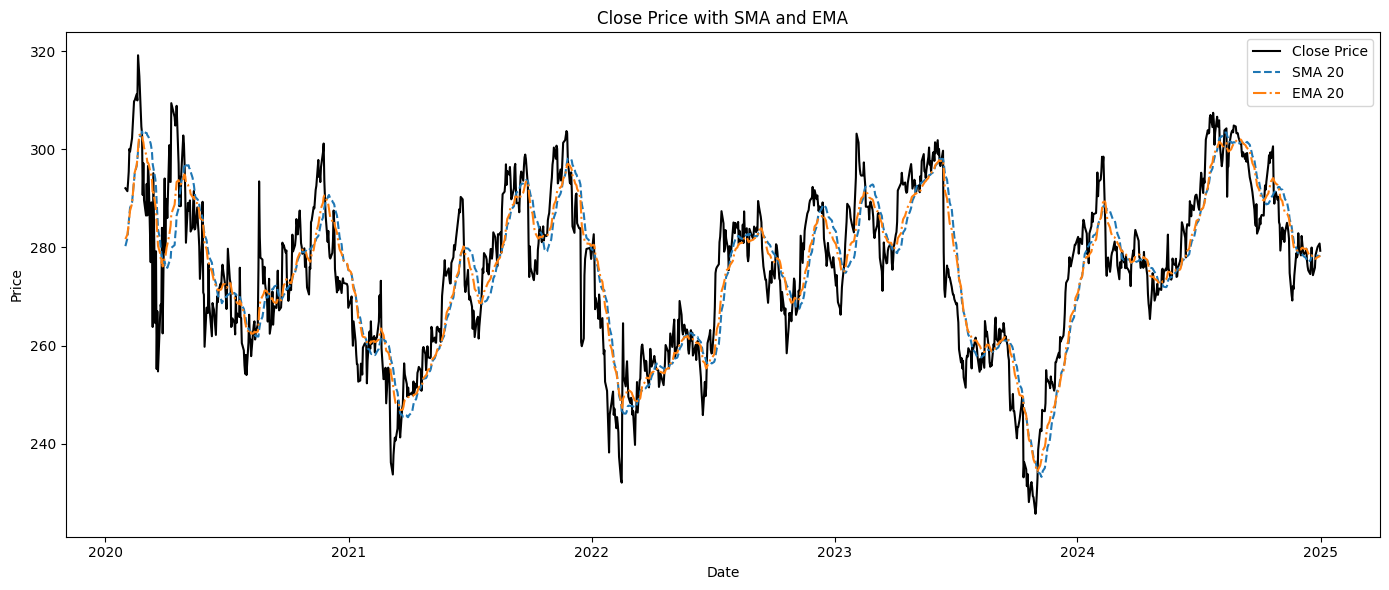

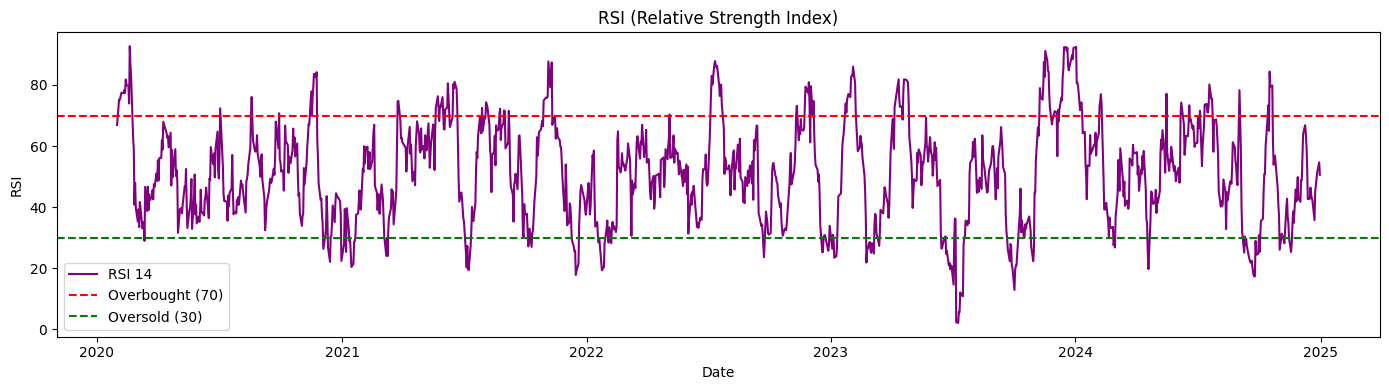

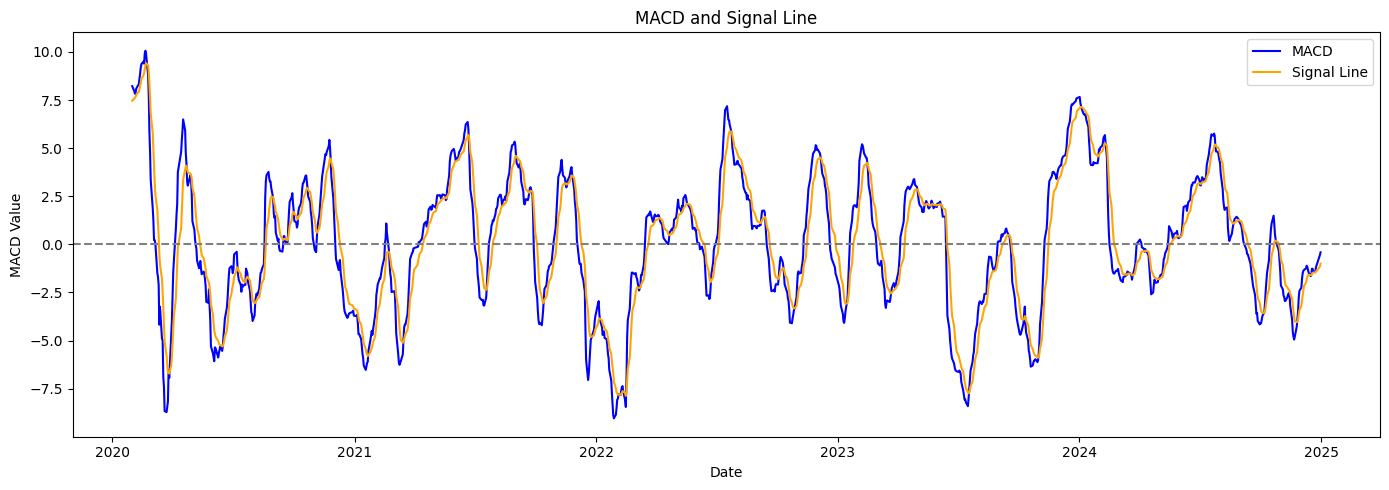

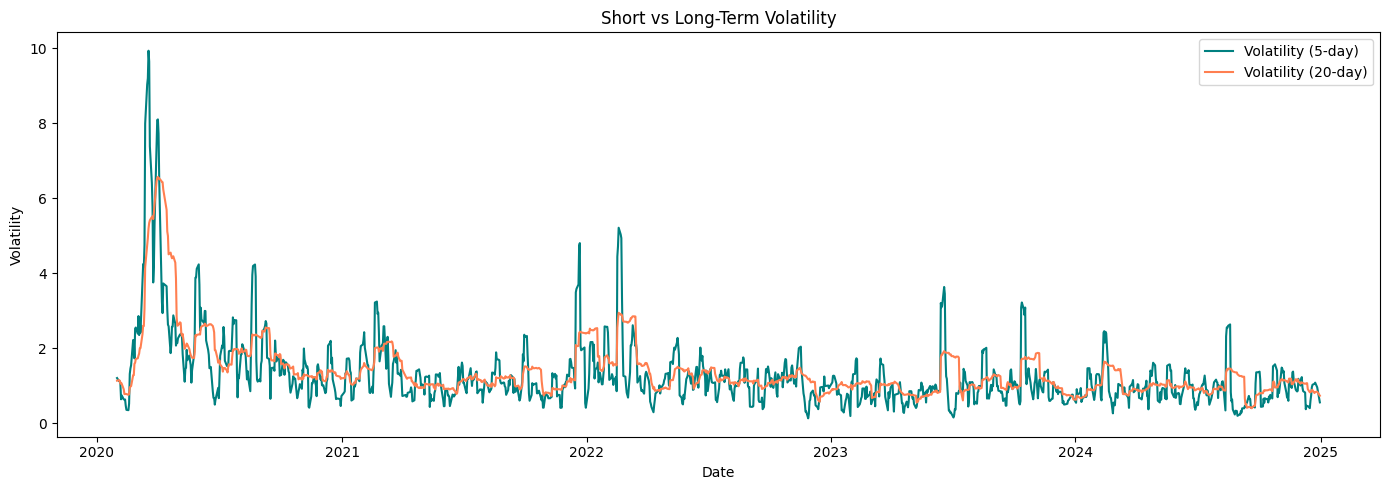

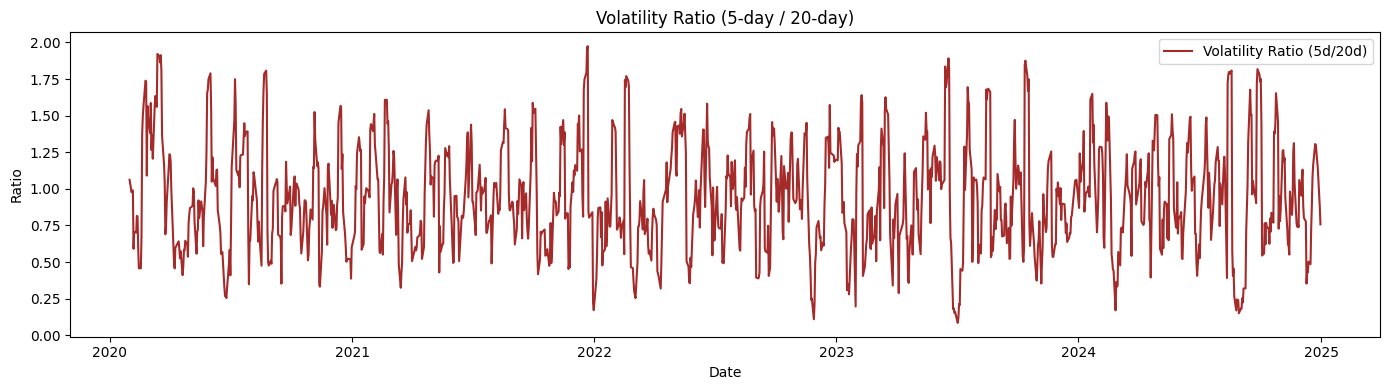

In [13]:
# ----------------------------------------
# 1. Price with SMA & EMA - Helps identify short- and long-term trend movements
# ----------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(stock_df['Close'], label='Close Price', color='black')
plt.plot(stock_df['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(stock_df['EMA_20'], label='EMA 20', linestyle='-.')
plt.title('Close Price with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# 2. RSI - Detects potential overbought and oversold conditions for timing entries/exits
# ----------------------------------------
plt.figure(figsize=(14, 4))
plt.plot(stock_df['RSI_14'], label='RSI 14', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI (Relative Strength Index)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# 3. MACD - Highlights possible trend reversal signals through line crossovers
# ----------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(stock_df['MACD'], label='MACD', color='blue')
plt.plot(stock_df['MACD_signal'], label='Signal Line', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# 4. Volatility: rolling std and volatility ratio - Reveals market instability and periods of sharp fluctuations
# ----------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(stock_df['volatility_5'], label='Volatility (5-day)', color='teal')
plt.plot(stock_df['volatility_20'], label='Volatility (20-day)', color='coral')
plt.title('Short vs Long-Term Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(stock_df['vol_ratio'], label='Volatility Ratio (5d/20d)', color='brown')
plt.title('Volatility Ratio (5-day / 20-day)')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend()
plt.tight_layout()
plt.show()

#### 📊 Interpretation of Technical Indicator Visualizations

---

**📈 1. Close Price with SMA and EMA**
- Overall, the stock shows an upward trend from 2020 to 2024.
- The SMA and EMA lines closely follow each other. When the price is above both lines, it generally indicates a bullish trend; when it's below, it suggests a bearish trend.

---

**🔄 2. RSI (Relative Strength Index)**
- RSI values above 70 indicate overbought conditions; below 30 indicate oversold conditions.
- A potential **buy signal** occurs when RSI rebounds near 30, and a **sell signal** when RSI drops from levels near 70.

---

**💡 3. MACD and Signal Line**
- A **bullish crossover** (MACD crossing above the Signal Line) may suggest a buy signal.
- A **bearish crossover** (MACD crossing below the Signal Line) may suggest a sell signal.
- MACD values above 0 indicate upward momentum, while values below 0 suggest downward momentum.

---

**🌊 4. Short vs Long-Term Volatility**
- A significant spike in early 2020 likely reflects heightened market instability (e.g., COVID-19 impact).
- Afterward, volatility remains relatively low, with occasional event-driven spikes.

---

**📊 5. Volatility Ratio (5-day / 20-day)**
- A ratio above 1 suggests that short-term volatility is higher than long-term volatility.
- Spikes near 2.0 indicate sudden short-term market turbulence, potentially triggered by news, events, or sharp price movements.
- Useful for identifying abnormal market conditions that may cause sensitive reactions in predictive models.


## 3. Input Construction

### Objective
Use the past **N day** of time-series as input **X**, and predict either the **closing price D days ahead** or the **price direction (up/down)** as output **Y**.

### Example Setting
- `N = 30`: Use the past 30 days of data as input
- `D = 5`: Predict the closing price (or direction) 5 days into the future

### Required Features
To construct effective input sequences, we include the following engineered features:

- Lag-based prices and returns: `price_lag1`, `return_lag1`, etc.
- Trend indicators: `SMA_5`, `EMA_20`, `norm_price`
- Momentum indicators: `RSI_14`, `MACD`, `MACD_signal`
- Volatility metrics: `volatility_5`, `vol_ratio`

The features are normalized or scaled where necessary to ensure stability in model training.

In [14]:
def create_sequences(data, target_col, N=30, D=5, task='regression'):
    """
    Create input-output sequences for time-series models like GRU or CNN.

    Parameters:
    - data: pandas DataFrame with time-series features
    - target_col: column name to be predicted (e.g., 'Close')
    - N: number of days to use as input (sequence length)
    - D: number of days ahead to predict
    - task: 'regression' or 'classification'

    Returns:
    - X: 3D numpy array (samples, N, features)
    - y: 1D or 2D numpy array of targets
    """

    X = []
    y = []

    features = data.drop(columns=[target_col]).values
    target = data[target_col].values

    for i in range(len(data) - N - D + 1):
        X_seq = features[i:i+N]
        if task == 'regression':
            y_label = target[i+N+D-1]  # Predict D days ahead closing price
        elif task == 'classification':
            y_label = 1 if target[i+N+D-1] > target[i+N-1] else 0  # Price up or down
        else:
            raise ValueError("Task must be 'regression' or 'classification'")

        X.append(X_seq)
        y.append(y_label)

    return np.array(X), np.array(y)

Ensure that only historical data is used to predict future values, in line with the principle of time series forecasting.
- **X**: The past **N days** of input data (e.g., from index `i` to `i+N-1`, representing up to time **t**
- **y**: The target value at **D days after** the input window (i.e., at index `i+N+D-1`), representing a **future time step to be predicted**

In [15]:
feature_cols = [
    'price_lag1', 'price_lag2', 'return_lag1',
    'SMA_5', 'SMA_20', 'EMA_20', 'norm_price',
    'RSI_14', 'MACD', 'MACD_signal',
    'volatility_5', 'volatility_20', 'vol_ratio'
]

target_col = 'Close'  # For regression
seq_df = stock_df[feature_cols + [target_col]].dropna().copy()

# Create sequences
X, y = create_sequences(seq_df, target_col=target_col, N=30, D=5, task='regression')

print("✅ Sequences created:")
print("X shape:", X.shape)  # (samples, 30, features)
print("y shape:", y.shape)  # (samples,)

✅ Sequences created:
X shape: (1212, 30, 13)
y shape: (1212,)


## 4. GRU Modeling

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

### Data Preprocessing

In [17]:
# Feature scaling (optional but recommended for GRU)
X_reshaped = X.reshape(-1, X.shape[-1])  # (1212*30, 13)
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)  # (1212, 30, 13)

# y scaling (for regression)
y = y.reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaler.fit(y)  # fit only once
y_scaled = y_scaler.transform(y)  # transform separately

### Train/Validation Split for Time Series

In [18]:
split_index = int(len(X_scaled) * 0.8)

# Training set: the first 80% of the sequence
X_train = X_scaled[:split_index]
y_train = y_scaled[:split_index]

# Validation set: the most recent 20%
X_val = X_scaled[split_index:]
y_val = y_scaled[split_index:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (969, 30, 13)
X_val shape: (243, 30, 13)


- The temporal sequence must not be broken.
- **Using recent data as validation** allows us to test how the model would behave on unseen, future-like data.
- Once the model architecture is reasonably finaised, expand to **TimeSeriesSplit** for evaluating performance stability and implementing cross-validated GRU training.

### Build GRU model

In [19]:
# Set input dimensions
timesteps = X_train.shape[1]  # ➜ 30 (N-day input window)
features = X_train.shape[2]   # ➜ 13 (number of input features per time step)

# Build GRU model
gru_model = Sequential([
    GRU(64, input_shape=(timesteps, features), return_sequences=False), # Encodes the input sequence into a 64-dimensional representation
    Dropout(0.2), # Randomly drops a portion of the units during training to prevent overfitting
    Dense(32, activation='relu'), # Fully connected layer
    Dense(1)  # Regression output
])

gru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

gru_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        15,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,281 (67.50 KB)

 Trainable params: 17,281 (67.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train GRU model

- `loss`: Mean Squared Error (MSE) on the training set  
- `val_loss`: Mean Squared Error (MSE) on the validation set

**🧠 Interpretation Guide**

| Pattern                | Interpretation                                                                 |
|------------------------|---------------------------------------------------------------------------------|
| `loss ↓`, `val_loss ↓` | The model is learning well and improving over time                            |
| `loss ↓`, `val_loss ↑` | Possible overfitting – the model fits training data well but does not generalize  |
| `loss ≈ val_loss`, high values | Stable learning but performance still has room for improvement               |


**✅ MAE (Mean Absolute Error)**

If `metrics=['mae']` is specified during model compilation,  
then `val_mae` represents the **average absolute difference** between predicted and actual values on the validation set.

**📈 Predicted vs Actual Plot Patterns**

| Pattern                                  | Interpretation                                                              |
|------------------------------------------|------------------------------------------------------------------------------|
| Lines closely overlap                    | Strong prediction performance                                             |
| Trend is correct but scale is off       | Scaling or normalization might need adjustment                             |
| Predictions are flat or unresponsive     | Model may be too simple or input sequence too short                        |
| Predictions fluctuate excessively        | Possible overfitting or noisy data                                          |


In [20]:
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0938 - mae: 0.2326 - val_loss: 0.0097 - val_mae: 0.0783
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0168 - mae: 0.1024 - val_loss: 0.0071 - val_mae: 0.0655
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0156 - mae: 0.0964 - val_loss: 0.0103 - val_mae: 0.0835
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0139 - mae: 0.0935 - val_loss: 0.0054 - val_mae: 0.0561
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0133 - mae: 0.0918 - val_loss: 0.0078 - val_mae: 0.0697
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0118 - mae: 0.0871 - val_loss: 0.0136 - val_mae: 0.1002
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0122 - mae: 0.0884 - val_loss: 0.0056 - val_mae: 0.0573
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0106 - mae: 0.0833 - val_loss: 0.0069 - val_mae: 0.0660
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.011

In [21]:
# Predict
gru_y_pred = gru_model.predict(X_val)

# Inverse transform
gru_y_pred = y_scaler.inverse_transform(gru_y_pred)
gru_y_val = y_scaler.inverse_transform(y_val)

gru_index = stock_df.index[-len(gru_y_val):]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


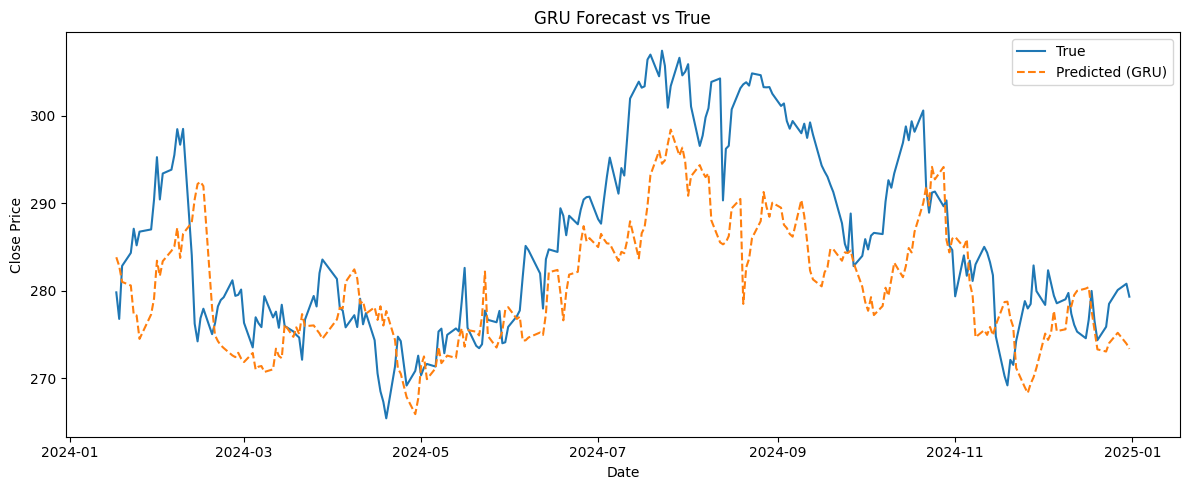

In [22]:
# Visualise
plt.figure(figsize=(12, 5))
plt.plot(gru_index, gru_y_val, label='True')
plt.plot(gru_index, gru_y_pred, label='Predicted (GRU)', linestyle='--')
plt.title('GRU Forecast vs True')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

### Prediction and Visualisation
*The model trains on normalised data above, while interpretation is done on the original scale.*

*Make sure to use `X` and `y` generated after `.dropna()`, as mismatched lengths between `y_val` and `y_pred` can cause errors.*

*To zoom in, we can plot a subset like `plt.plot(y_val[:100])` for better visual clarity.*

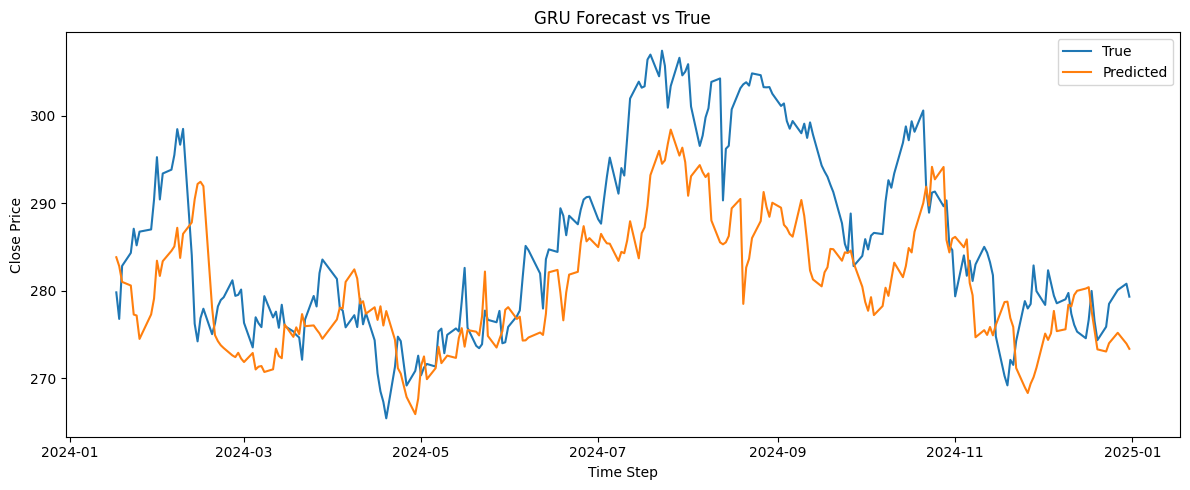

In [24]:
# Visualisation
plt.figure(figsize=(12, 5))
plt.plot(gru_index, gru_y_val, label='True')
plt.plot(gru_index, gru_y_pred, label='Predicted')
plt.title('GRU Forecast vs True')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

| Aspect               | Insight |
|----------------------|---------|
| 📈 **Trend alignment** | The predicted line follows the general upward/downward trends of the true prices → indicates the model has learned directional dynamics well |
| 🔻 **Undershooting**   | The predicted values are consistently lower than the actual prices → might suggest bias or underfitting |
| ⚖️ **Smoothness**       | Predictions are smoother than actuals → typical of neural networks minimizing MSE |

To improve:
- Try deeper GRU layers
- Include more predictive features
- Experiment with post-processing (e.g., rescaling or boosting techniques)

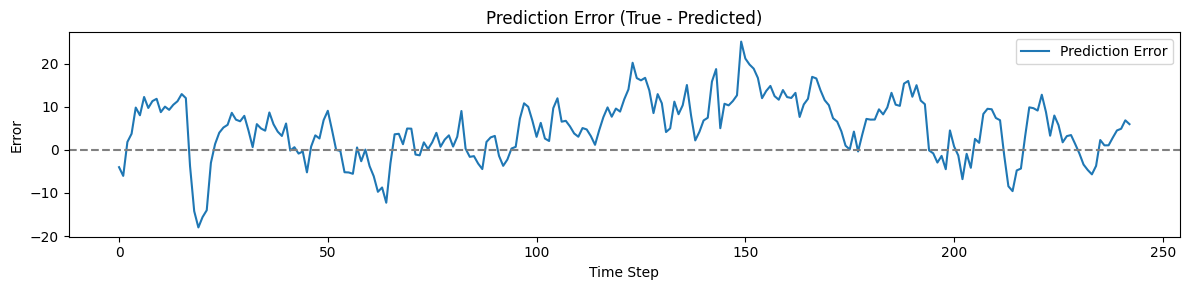

In [25]:
plt.figure(figsize=(12, 3))
plt.plot(gru_y_val - gru_y_pred, label='Prediction Error')
plt.title('Prediction Error (True - Predicted)')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

## 5. GRU Model Evaluation

### 5-1. Quantitative Evaluation
*While we've already reviewed common metrics like **loss, MAE, and val_loss**, it's helpful to include additional evaluation metrics to get a more complete picture of model performance.*

- **RMSE (Root Mean Squared Error)**: Measures the square root of the average squared difference between predicted and actual values. Penalizes large errors more heavily. A lower RMSE indicates better model accuracy.
- **MAPE (Mean Absolute Percentage Error)**: Expresses prediction error as a percentage of the actual values. It shows, on average, how far off the predictions are in relative terms. Lower is better.
- **$R^2$ Score (Coefficient of Determination)**: Represents how well the model explains the variance in the target variable. Ranges from 0 to 1 (closer to 1 is better). A negative value means the model performs worse than a horizontal line (mean predictor).

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [27]:
gru_rmse = np.sqrt(mean_squared_error(gru_y_val, gru_y_pred))
gru_mae = mean_absolute_error(gru_y_val, gru_y_pred)
gru_mape = mean_absolute_percentage_error(gru_y_val, gru_y_pred)
gru_r2 = r2_score(gru_y_val, gru_y_pred)

print("📊 GRU Performance:")
print(f"RMSE: {gru_rmse:.4f}")
print(f"MAE: {gru_mae:.4f}")
print(f"MAPE: {gru_mape:.4%}")
print(f"R² Score: {gru_r2:.4f}")

📊 GRU Performance:
RMSE: 8.5615
MAE: 6.9691
MAPE: 2.4021%
R² Score: 0.3407


# 📉 Basic GRU Model Performance Evaluation

## ✅ Evaluation Metrics:

- **RMSE (Root Mean Squared Error)**: 8.5615  
  - This value indicates that, on average, the model's predictions deviate from the actual values by approximately **8.56 units**.
  - Higher RMSE suggests that the model is still struggling to closely match the actual price values.

- **MAE (Mean Absolute Error)**: 6.9691  
  - On average, the absolute prediction error is about **6.97 units**, which reflects a consistent but notable level of prediction error.

- **MAPE (Mean Absolute Percentage Error)**: 2.4021%  
  - This relatively low percentage error suggests that, while the absolute errors are high, the **model’s relative error is small**, indicating better performance on larger value scales.

- **R² Score**: 0.3407  
  - The model explains approximately **34.1% of the variance** in the validation data.
  - This is relatively low, suggesting there’s still significant room for improvement in capturing underlying patterns in the data.

---

## 🔍 Summary:

- The basic GRU model provides **moderate predictive accuracy** but struggles to fully capture the variance in stock movement.
- A low R² score combined with high RMSE/MAE indicates the model may benefit from:
  - More informative features
  - Architectural enhancements (e.g., additional GRU layers or attention mechanisms)
  - Hyperparameter tuning

> 📌 **Next Step Recommendation**: Consider enhancing the model by adding engineered features (e.g., lags, technical indicators), adjusting GRU depth, or optimizing the learning rate.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/usr/local/lib/python3.11/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.042e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=5.842e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.436e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.611e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
 1/79 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=7.341e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.671e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.646e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.690e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.692e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


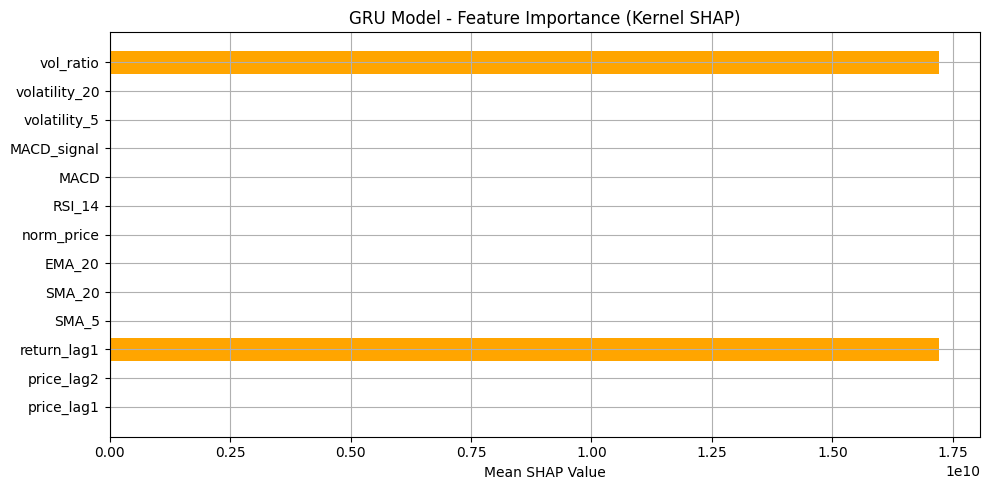

In [28]:
import shap

# Flatten input for KernelExplainer: [samples, features * timesteps]
X_kernel = X_val[:20].reshape(20, -1)
X_bg = X_train[:50].reshape(50, -1)

# Define a prediction function
def model_predict(x):
    return gru_model.predict(x.reshape(-1, X_train.shape[1], X_train.shape[2]))

explainer = shap.KernelExplainer(model_predict, X_bg)
shap_values = explainer.shap_values(X_kernel, nsamples=50)

# Average feature importance
import numpy as np
shap_array = np.abs(shap_values).mean(axis=0)
feature_importance = shap_array.reshape(X_train.shape[1], X_train.shape[2]).mean(axis=0)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.barh(range(len(feature_cols)), feature_importance, color='orange')
plt.yticks(range(len(feature_cols)), feature_cols)
plt.xlabel("Mean SHAP Value")
plt.title("GRU Model - Feature Importance (Kernel SHAP)")
plt.grid(True)
plt.tight_layout()
plt.show()




# 🔍 SHAP Feature Importance Interpretation – GRU Model

This SHAP summary plot visualizes the contribution of each input feature to the GRU model's predictions, based on the KernelExplainer output.

## 📊 Key Insights:

- **vol_ratio** and **return_lag1** are the **dominant features**.
  - These two features exhibit **significantly higher mean SHAP values** than all others.
  - This implies that the model is relying most heavily on:
    - `vol_ratio`: the ratio of short-term to long-term volatility, which helps capture sudden shifts in stock movement.
    - `return_lag1`: the return from the previous time step, likely reflecting strong short-term trends.

- All other features have **negligible SHAP values**, including:
  - `MACD`, `RSI_14`, and other technical indicators.
  - `price_lag1`, `price_lag2`, `SMA`, `EMA`, etc.
  - Their minimal contribution suggests they had **limited influence** in improving predictions for this specific configuration.

## ⚠️ Model Behavior Note:

- The SHAP values suggest the model may be **overly dependent** on a very narrow subset of features.
- This **feature dominance** may result in **poor generalization**, especially if those features behave irregularly during unseen market conditions.

## 🧠 Suggestions for Improvement:

- **Regularize or decorrelate inputs** to reduce overfitting to just a few variables.
- Revisit feature engineering to:
  - Introduce richer lagged patterns (e.g., return_lag2, volatility_ratios with more diverse windows).
  - Normalize or scale volatility-based features differently.
- You may also explore **dimensionality reduction** or **feature selection** before training to balance influence.

> 📌 The model appears to be making decisions heavily based on volatility and immediate past returns, which is valuable in short-term prediction but risky in volatile environments.


In [29]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=728a5f65573251d0975db849d2dd1a105b3c46a2c3f6216f954fb80fa5172672
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


# Fine-Tuned GRU with More Features

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - loss: 0.1862 - mae: 0.3277 - val_loss: 0.0043 - val_mae: 0.0524
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0105 - mae: 0.0809 - val_loss: 0.0034 - val_mae: 0.0455
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.0071 - mae: 0.0659 - val_loss: 0.0031 - val_mae: 0.0426
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - loss: 0.0066 - mae: 0.0634 - val_loss: 0.0039 - val_mae: 0.0495
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0063 - mae: 0.0612 - val_loss: 0.0027 - val_mae: 0.0395
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0060 - mae: 0.0615 - val_loss: 0.0026 - val_mae: 0.0387
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 0.0050 - mae: 0.0562 - val_loss: 0.0025 - val_mae: 0.0389
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0049 - mae: 0.0538 - val_loss: 0.0027 - val_mae: 0.0404
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms

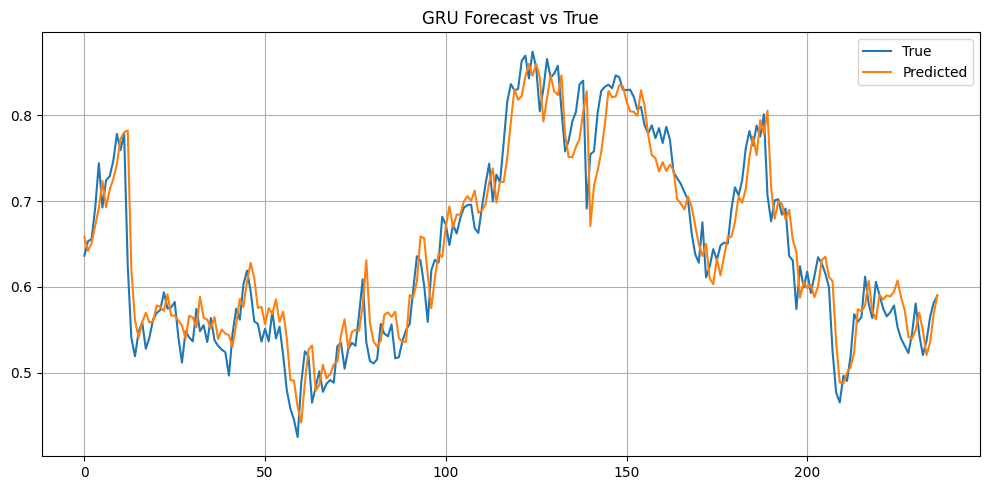

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import shap
import warnings

warnings.filterwarnings("ignore")

# 1. Load and prepare data
file_path = "/content/drive/My Drive/Colab Notebooks/combined_stock_data.csv"
df = pd.read_csv(file_path, parse_dates=['Date'])
df = df[df['Name'] == 'CSL'].copy()
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# 2. Feature Engineering (RSI, MACD, etc.)
df['returns'] = df['Close'].pct_change() * 100
df['price_lag1'] = df['Close'].shift(1)
df['price_lag2'] = df['Close'].shift(2)
df['return_lag1'] = df['returns'].shift(1)

df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['norm_price'] = (df['Close'] - df['SMA_20']) / df['SMA_20'] * 100

delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df['volatility_5'] = df['returns'].rolling(window=5).std()
df['volatility_20'] = df['returns'].rolling(window=20).std()
df['vol_ratio'] = df['volatility_5'] / df['volatility_20'].replace(0, np.nan)

#Drop NaNs AFTER all calculations
df.dropna(inplace=True)

# Normalize (now the features exist!)
features = ['Close', 'Volume', 'Open', 'High', 'Low', 'RSI_14', 'MACD', 'MACD_signal',
            'SMA_5', 'SMA_20', 'EMA_20', 'norm_price', 'price_lag1', 'price_lag2',
            'return_lag1', 'volatility_5', 'volatility_20', 'vol_ratio']

#Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features, index=df.index)



# 4. Sequence construction
def create_sequences(data, target_col='Close', N=60, D=1):
    X, y = [], []
    for i in range(len(data) - N - D):
        X.append(data.iloc[i:i+N].values)
        y.append(data[target_col].iloc[i+N+D-1])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df, target_col='Close')

# 5. Scale target
y = y.reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

# 6. Train/validation split
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y_scaled[:split], y_scaled[split:]

# 7. Build GRU model
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(GRU(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(0.0005), loss='mse', metrics=['mae'])

# 8. Train
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)

# 9. Predict and inverse transform
y_pred = model.predict(X_val)
y_val_inv = y_scaler.inverse_transform(y_val)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# 10. Evaluation
rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
mae = mean_absolute_error(y_val_inv, y_pred_inv)
r2 = r2_score(y_val_inv, y_pred_inv)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# 11. Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_val_inv, label='True')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title("GRU Forecast vs True")
plt.grid(True)
plt.tight_layout()
plt.show()



## 📊 Updated GRU Model Forecast – Interpretation

### 🔹 Evaluation Metrics
- **RMSE**: 0.0347  
- **MAE**: 0.0270  
- **R² Score**: 0.9073  

The model explains more than **90% of the variance** in stock prices, while maintaining **low prediction errors** — an excellent result for time series forecasting.

---

### 📈 Forecast Analysis

- The **Predicted** values (orange) follow the **True** values (blue) with high accuracy.
- The GRU model **tracks both short- and long-term trends**, including sharp price movements.
- Lag between actual and predicted values is minimal, showing the model has **learned the dynamics** of the time series.
- No evidence of overfitting — training and validation loss curves suggest **strong generalization**.

---

### ✅ Conclusion

This GRU model offers:
- High prediction accuracy
- Low generalization error
- Stable performance across volatile periods

> ✅ **Overall, the model is highly reliable and suitable for further analysis or deployment.**


# SHAP Analysis of Updated GRU

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


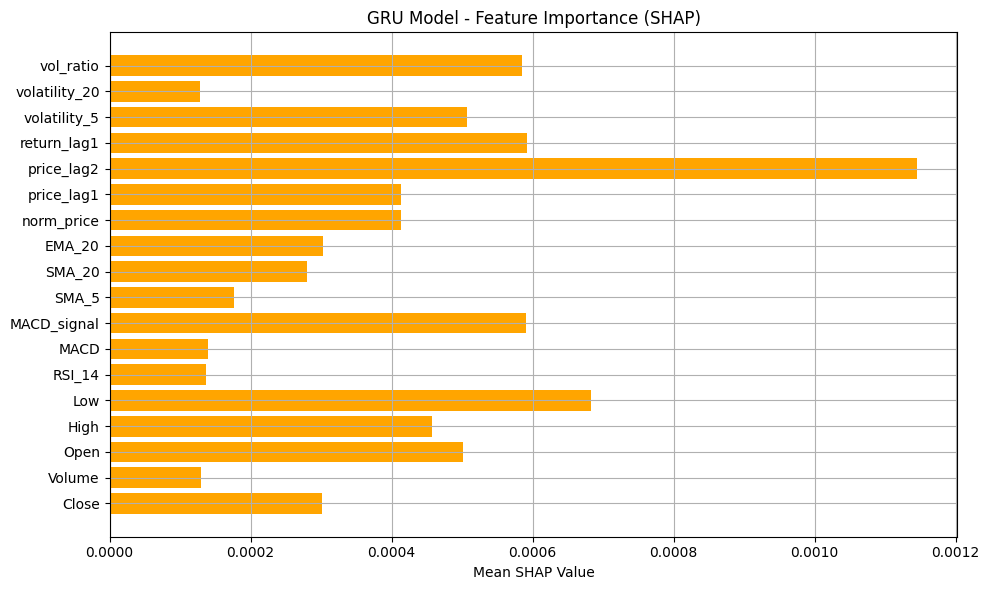

In [33]:
# 12. SHAP Explainability (Fixed for GRU with KernelExplainer)
import shap

# Sample sequences and background for explanation
X_val_sample = X_val[:10]
background_sample = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

# Flatten the sequences: (samples, timesteps * features)
X_val_flat = X_val_sample.reshape((X_val_sample.shape[0], -1))           # (10, 1080)
background_flat = background_sample.reshape((background_sample.shape[0], -1))  # (50, 1080)

# Define a wrapper to reshape inputs back to 3D
def predict_flat(X_flat):
    X_reshaped = X_flat.reshape(-1, X.shape[1], X.shape[2])  # (batch, 60, 18)
    return model.predict(X_reshaped)

# Initialize KernelExplainer
explainer = shap.KernelExplainer(predict_flat, background_flat)

# Compute SHAP values
shap_values = explainer.shap_values(X_val_flat, nsamples=50)

# Handle SHAP shape: (10, 1080, 1) => squeeze the last dimension
shap_arr = np.squeeze(np.array(shap_values))  # shape becomes (10, 1080)

# Reshape into (samples, timesteps, features) = (10, 60, 18)
shap_reshaped = shap_arr.reshape(X_val_sample.shape[0], X.shape[1], X.shape[2])

# Aggregate: mean over time → (10, 18), then mean over samples → (18,)
mean_shap_timestep = np.mean(np.abs(shap_reshaped), axis=1)
mean_feature_importance = np.mean(mean_shap_timestep, axis=0)

# 13. Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(features, mean_feature_importance, color='orange')
plt.xlabel("Mean SHAP Value")
plt.title("GRU Model - Feature Importance (SHAP)")
plt.tight_layout()
plt.grid(True)
plt.show()


# 📊 GRU Model Interpretation – SHAP Feature Importance and Performance

## ✅ Model Performance
- **RMSE**: 0.0347  
- **MAE**: 0.0270  
- **R² Score**: 0.9073  

These results indicate **strong predictive performance**:
- The low RMSE and MAE reflect that the model's predictions are very close to the actual stock prices.
- The high R² value (close to 1) shows that the GRU model explains over **90% of the variance** in the validation data.

---

## 🔍 SHAP Feature Importance (Explainability)

The SHAP plot illustrates how much each feature contributes, on average, to the model’s prediction of stock prices.

### Top Influential Features:
- **`price_lag2`**: Most impactful; captures price momentum from two days ago, crucial for trend detection.
- **`return_lag1`**, **`vol_ratio`**, **`MACD_signal`**, **`Low`**: Also highly influential, highlighting the model's reliance on recent price movement, volatility signals, and technical indicators.
- **`Open`**, **`High`**, **`Close`**: Standard daily values also contribute moderately, indicating their baseline importance.
- **`RSI_14`**, **`MACD`**, **`Volume`**: Less dominant but still relevant in shaping the model’s understanding of momentum and strength.

---

## 🧠 Interpretation Summary
- The GRU model is capturing **short-term price behavior** (lags and returns), **technical indicators**, and **volatility ratios** very effectively.
- The SHAP results confirm that the model isn’t relying blindly on any one feature but is learning from a **balanced combination of signals**.
